In [56]:
%pylab inline
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import numpy as np
chunk='chunk23'
topdir =  '/global/cscratch1/sd/huikong/obiwan_Aug/repos_for_docker/obiwan_out/subset/'
fn =  'eBOSS_ELG_full_ALL_v4.dat_cutted_kaylan_really_masked_chunk23.fits'
fn_obiwan = 'ngc_tractor_sim_match_really_masked_chunk23.fits'
fn_sim = 'ngc_sim_really_masked_chunk23.fits'
DAT = fits.getdata(topdir+fn)
obiwan = fits.getdata(topdir+fn_obiwan)
sim = fits.getdata(topdir+fn_sim)
sim_m=sim

Populating the interactive namespace from numpy and matplotlib


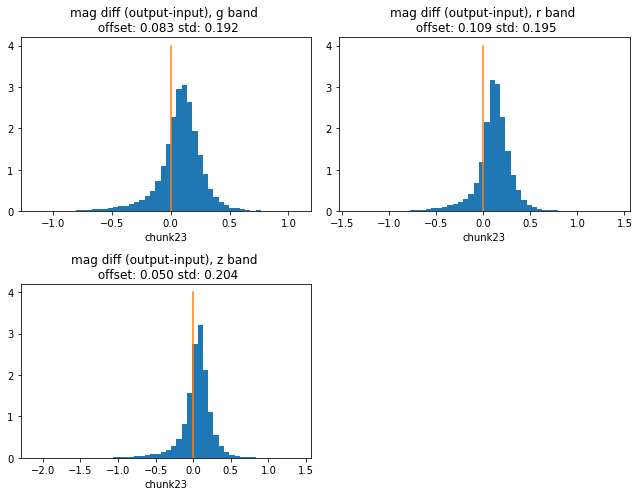

In [57]:
#magnitude offset
def MAG(mag, Type):
    if Type=='obiwan':
        data=obiwan
        g     = 22.5 - 2.5 * np.log10(data['flux_g'] / data['mw_transmission_g'])
        r_mag = 22.5 - 2.5 * np.log10(data['flux_r'] / data['mw_transmission_r'])
        z_mag = 22.5 - 2.5 * np.log10(data['flux_z'] / data['mw_transmission_z'])
    if Type=='sim':
        data=obiwan
        g     = 22.5 - 2.5 * np.log10(data['sim_gflux'] / data['sim_mw_transmission_g'])
        r_mag = 22.5 - 2.5 * np.log10(data['sim_rflux'] / data['sim_mw_transmission_r'])
        z_mag = 22.5 - 2.5 * np.log10(data['sim_zflux'] / data['sim_mw_transmission_z'])
    if Type=='uniform':
        data = sim
        g     = 22.5 - 2.5 * np.log10(data['gflux'] / data['mw_transmission_g'])
        r_mag = 22.5 - 2.5 * np.log10(data['rflux'] / data['mw_transmission_r'])
        z_mag = 22.5 - 2.5 * np.log10(data['zflux'] / data['mw_transmission_z'])
    if mag == 'g':
        return g
    if mag == 'r':
        return r_mag
    if mag == 'z':
        return z_mag
    

    
def offset(mag, plot_index, data = obiwan):
    plt.subplot(2,2,plot_index)
    mag_diff = MAG(mag,'obiwan') - MAG(mag,'sim')
    n, bins, patches = plt.hist(mag_diff,bins = 50,normed = True)
    y = np.arange(n.max()+1)
    x = np.zeros(len(y))
    plt.plot(x,y)
    plt.xlabel(chunk)
    plt.title('mag diff (output-input), %s band \n offset: %.3f std: %.3f' % (mag, mag_diff.mean(), mag_diff.std()))
plt.figure(figsize = (9,7))
offset('g',1)
offset('r',2)
offset('z',3)
plt.tight_layout()

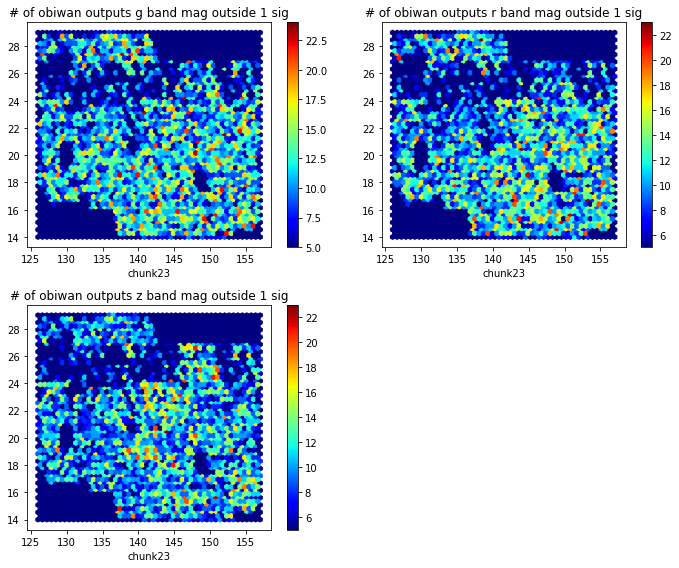

In [58]:
def mag_dist(mag,plt_idx, data = obiwan):
    mag_diff = MAG(mag,'obiwan') - MAG(mag,'sim')
    sup = mag_diff.mean() + mag_diff.std()
    inf = mag_diff.mean() - mag_diff.std()
    sel = (mag_diff<sup)&(mag_diff>inf)
    dat_sel = data[sel==False] 
    plt.subplot(2,2,plt_idx)
    plt.hexbin(dat_sel['ra'],dat_sel['dec'],gridsize = 50, cmap = 'jet',vmin=5)
    plt.colorbar()
    plt.xlabel(chunk)
    plt.title('# of obiwan outputs '+mag+' band mag outside 1 sig')    

plt.figure(figsize = (10,8))
mag_dist('g',1)
mag_dist('r',2)
mag_dist('z',3)
plt.tight_layout()

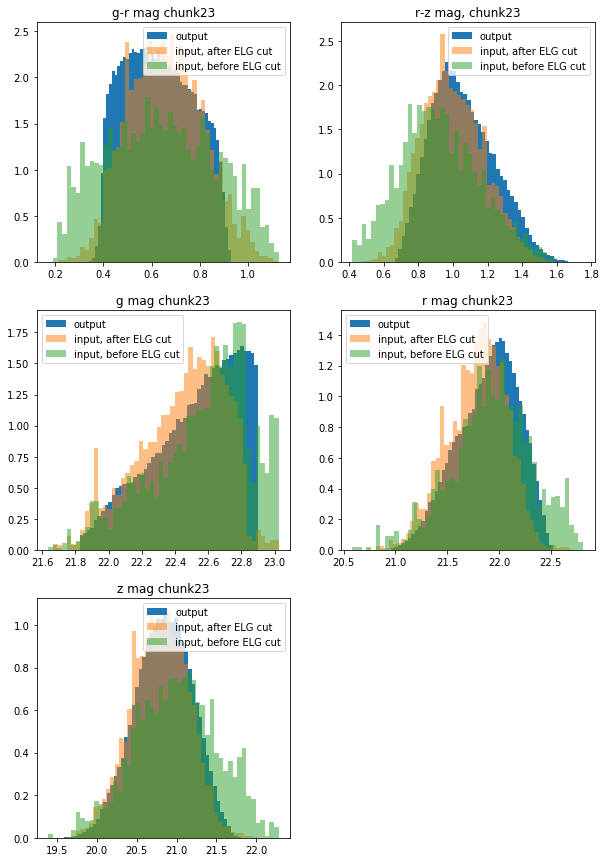

In [59]:
def mag_alg_hist(TYPE, plt_idx, data = obiwan):
    plt.subplot(3,2,plt_idx)
    bin_arg = dict(bins = 50, stacked = False, normed=True)
    if TYPE == 'g-r':
        #g-r hist input,output (to ELG cut)
        plt.hist(MAG('g','obiwan')-MAG('r','obiwan'),label = 'output', **bin_arg)
        plt.hist(MAG('g','sim') - MAG('r','sim'), label = 'input, after ELG cut',alpha = 0.5, **bin_arg)
        plt.hist(MAG('g','uniform') - MAG('r','uniform'), label = 'input, before ELG cut', alpha=0.5, **bin_arg)
        plt.legend()
        plt.title('g-r mag ' + chunk)
    elif TYPE == 'r-z':
        #r-z hist input,output (to ELG cut)
        plt.hist(MAG('r','obiwan')-MAG('z','obiwan'),label = 'output', **bin_arg)
        plt.hist(MAG('r','sim') - MAG('z','sim'), label = 'input, after ELG cut',alpha=0.5, **bin_arg)
        plt.hist(MAG('r','uniform') - MAG('z','uniform'), label = 'input, before ELG cut', alpha=0.5, **bin_arg)
        plt.legend()
        plt.title('r-z mag, chunk23') 
    else:
        assert(TYPE in ['g','r','z'])
        plt.hist(MAG(TYPE,'obiwan'),label = 'output', **bin_arg)
        plt.hist(MAG(TYPE,'sim'), label = 'input, after ELG cut',alpha=0.5, **bin_arg)
        plt.hist(MAG(TYPE,'uniform'), label = 'input, before ELG cut',alpha=0.5, **bin_arg)
        plt.legend()
        plt.title(TYPE+' mag '+chunk)
plt.figure(figsize = (10,15))
mag_alg_hist('g-r',1)
mag_alg_hist('r-z',2)
mag_alg_hist('g',3)
mag_alg_hist('r',4)
mag_alg_hist('z',5)

In [60]:
def compare_obiwan(res = 256, obiwan = obiwan):
    import healpy as hp
    #mean <mag-mag_true> plot g,r,z
    pixs = hp.ang2pix(res,obiwan['ra'],obiwan['dec'],nest = True, lonlat = True)
    pixs2 = hp.ang2pix(res,sim_m['ra'], sim_m['dec'], nest = True, lonlat = True)
    pixs3 = hp.ang2pix(res,DAT['ra'],DAT['dec'],nest = True, lonlat = True)
    N = 12*res**2
    hist_n = np.zeros(N)
    hist_mag_diff_g = np.zeros(N)
    hist_mag_diff_r = np.zeros(N)
    hist_mag_diff_z = np.zeros(N)
    mag_g = MAG('g','obiwan')
    mag_r =  MAG('r', 'obiwan')
    mag_z = MAG('z', 'obiwan')
    sim_mag_g =  MAG('g','sim')
    sim_mag_r =  MAG('r','sim')
    sim_mag_z =  MAG('z','sim')
    for i in range(len(pixs)):
        n = pixs[i]
        mag_diff_g = mag_g[i] - sim_mag_g[i]
        mag_diff_r = mag_r[i] - sim_mag_g[i]
        mag_diff_z = mag_z[i] - sim_mag_g[i]
        hist_mag_diff_g[n]+=mag_diff_g
        hist_mag_diff_r[n]+=mag_diff_r
        hist_mag_diff_z[n]+=mag_diff_z
        hist_n[n]+=1
    hist2 = np.zeros(N)
    for i in range(len(pixs2)):
        n = pixs2[i]
        hist2[n]+=1
    hist3 = np.zeros(N)
    for i in range(len(pixs3)):
        n = pixs3[i]
        hist3[n]+=1

    
    N = 12*res**2
    ra,dec = hp.pix2ang(res,np.arange(N), nest = True,lonlat = True)
    col1 = fits.Column(name = 'ra', array = ra, format = 'D')
    col2 = fits.Column(name = 'dec', array = dec, format = 'D')
    # # of obiwans in each pixel
    col3 = fits.Column(name = 'num_obiwan', array = hist_n, format = 'D')
    col4 = fits.Column(name = 'hist_mag_diff_g', array = hist_mag_diff_g, format = 'D')
    col5 = fits.Column(name = 'hist_mag_diff_r', array = hist_mag_diff_r, format = 'D')
    col6 = fits.Column(name = 'hist_mag_diff_z', array = hist_mag_diff_z, format = 'D')
    # # of uniform randoms in each pixel
    col7 = fits.Column(name = 'num_uniform', array = hist2, format = 'D')
    # # of real elgs in each pixel
    col8 = fits.Column(name = 'num_elgs', array = hist3, format = 'D')
    
    #bad pixels
    g = sim_mag_g
    rz = sim_mag_r - sim_mag_z
    gr = sim_mag_g - sim_mag_r
    color_sgc = (g>21.825)&(g<22.825)&(-0.068*rz+0.457<gr)&(gr< 0.112*rz+0.773) &(0.218*gr+0.571<rz)&(rz<-0.555*gr+1.901)
    dat_bad = obiwan[color_sgc==False]
    pixs_bad = hp.ang2pix(res,dat_bad['ra'],dat_bad['dec'],nest = True, lonlat = True)
    hist_bad = np.zeros(N)
    for i in range(len(pixs_bad)):
        n = pixs_bad[i]
        hist_bad[n]+=1
    col9 = fits.Column(name = 'num_bad', array = hist_bad, format = 'D')
    dat = fits.BinTableHDU.from_columns([col1,col2,col3,col4,col5,col6,col7,col8,col9]).data
    uni = dat['num_uniform']
    sel = (uni>0)
    return dat[sel]
#obiwan rearanged in healpix format
compact_obiwan = compare_obiwan()

'\noutput update:\n** DAT: real elgs\n** obiwan: obiwan output\n** sim_m: uniform randoms\n** compact_obiwan -- hp outputs\n** hp_obiwan -- hp outputs w/ cut to > 350 uniforms per pix\n'

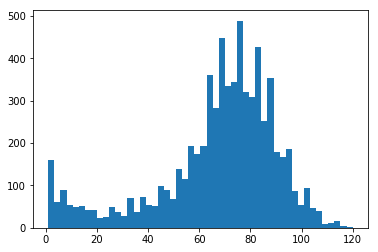

In [61]:
pt = plt.hist(compact_obiwan['num_uniform'],bins=50)
#have a cut @ 40
def cut_uni(cut_set = 40):
    uni = compact_obiwan['num_uniform']
    sel = (uni>cut_set)
    hp_obiwan = compact_obiwan[sel]
    return hp_obiwan
hp_obiwan = cut_uni()

'''
output update:
** DAT: real elgs
** obiwan: obiwan output
** sim_m: uniform randoms
** compact_obiwan -- hp outputs
** hp_obiwan -- hp outputs w/ cut to > 350 uniforms per pix
'''

In [62]:
import healpy as hp
N = 12*128**2
pixs2 = hp.ang2pix(128,sim_m['ra'], sim_m['dec'], nest = True, lonlat = True)
hist2 = np.zeros(N)

for i in range(462556):
        n = pixs2[i]
        hist2[n]+=1

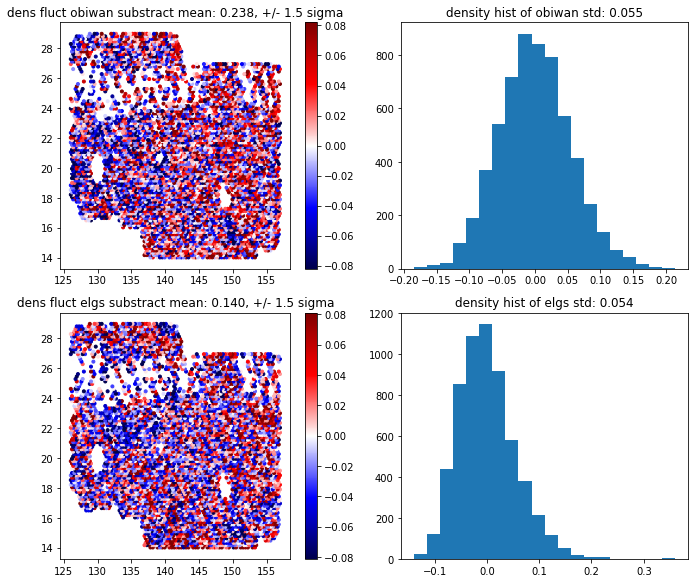

In [66]:
#number density fluctuation
def nb_dens_fluc(TYPE,plt_idx,data = hp_obiwan):
    plt.subplot(3,2,plt_idx)
    assert(TYPE in ['obiwan','elgs','obiwan-0.6<z<1.1'])
    if TYPE == 'obiwan' or TYPE == 'obiwan-0.6<z<1.1':
        color = data['num_obiwan']/data['num_uniform']
    else:
        color = data['num_elgs']/data['num_uniform']
    mean = color.mean()
    std = color.std()
    plt.scatter(data['ra'],data['dec'],c=color-mean,cmap = 'seismic',vmin = -std*1.5,vmax = 1.5*std,marker='.')
    plt.colorbar()
    plt.title('dens fluct '+ TYPE +' substract mean: %.3f, +/- 1.5 sigma' % mean)
    plt.subplot(3,2,plt_idx+1)
    plt.hist(color-mean,bins = 20)
    std = (color-mean).std()
    plt.title('density hist of '+ TYPE +' std: %.3f' % std)
plt.figure(figsize = (10,12))
nb_dens_fluc('obiwan',1)
nb_dens_fluc('elgs',3)



#number density fluctuation for obiwan at 0.6<z<1.1
def nb_dens_fluc_w_redshift_cut(plt_idx = 5, z_min = 0.6,zmax = 1.1):
    redshift = obiwan['redshift']
    obiwan_sel = (redshift<1.1)&(redshift>0.6)
    obiwan_rf_cut = obiwan[obiwan_sel]
    obiwan_rf_cutted = compare_obiwan(res = 128, obiwan = obiwan_rf_cut)
    uni = obiwan_rf_cutted['num_uniform']
    sel = (uni>350)
    hp_obiwan_cutted = compact_obiwan[sel]
    plt.subplot(3,2,plt_idx)
    nb_dens_fluc('obiwan-0.6<z<1.1',plt_idx,data = hp_obiwan_cutted)
    
#nb_dens_fluc_w_redshift_cut()
plt.tight_layout()

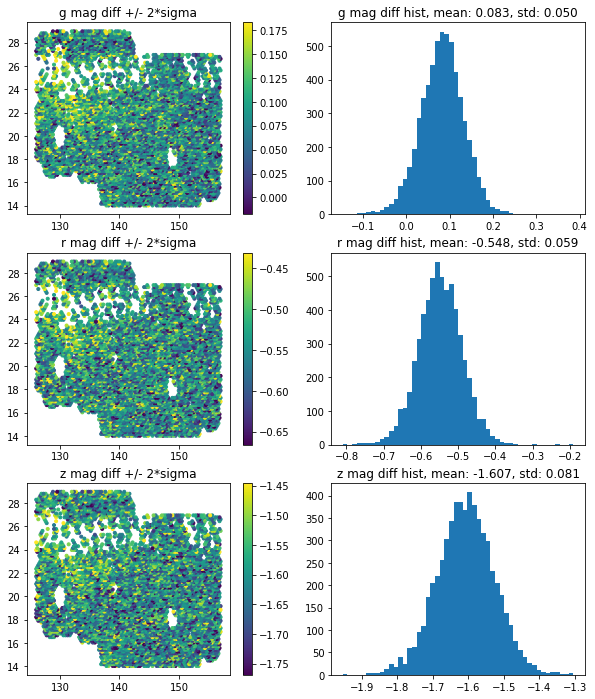

In [67]:
def plt_gen(Color, plt_idx, dat = hp_obiwan):
    plt.subplot(3,2,plt_idx)
    color = dat['hist_mag_diff_'+Color]/dat['num_obiwan']
    mean,std = color.mean(),color.std()
    sc = plt.scatter(hp_obiwan['ra'],hp_obiwan['dec'],c=color,vmin = mean-2*std, vmax = mean+2*std,marker='.')
    plt.colorbar(sc)
    plt.title(Color+' mag diff +/- 2*sigma')
    plt.subplot(3,2,plt_idx+1)
    pt = plt.hist(color,bins = 50)
    plt.title(Color+' mag diff hist, mean: %.3f, std: %.3f' % (mean,std))

plt.figure(figsize=(10,12))    
plt_gen('g',1)
plt_gen('r',3)
plt_gen('z',5)

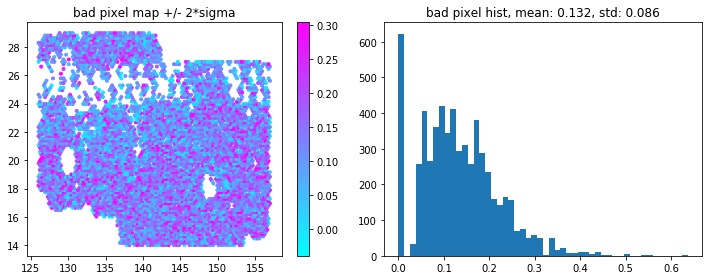

In [68]:
#bad pixel map
def bd_pix_plt_gen(dat = hp_obiwan):
    plt.subplot(1,2,1)
    color = dat['num_bad']/dat['num_obiwan']
    mean,std = color.mean(),color.std()
    sc = plt.scatter(hp_obiwan['ra'],hp_obiwan['dec'],c=color,cmap = 'cool',vmin = mean-2*std, vmax = mean+2*std,marker='.')
    plt.colorbar(sc)
    plt.title('bad pixel map +/- 2*sigma')
    plt.subplot(1,2,2)
    pt = plt.hist(color,bins = 50)
    plt.title('bad pixel hist, mean: %.3f, std: %.3f' % (mean,std))
plt.figure(figsize = (10,4))
bd_pix_plt_gen()
plt.tight_layout()

Text(0.5,0,'number of incidents')

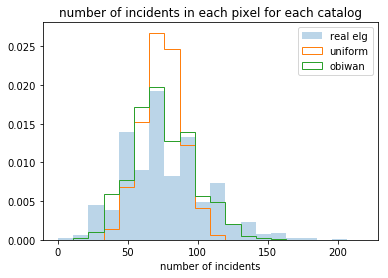

In [69]:
#n_gal/n_obi 
#find n_obi in each pixel, 
sum1 = hp_obiwan['num_uniform'].sum()
sum2 = hp_obiwan['num_elgs'].sum()
sum3 = hp_obiwan['num_obiwan'].sum()
n,bins,patches = plt.hist(hp_obiwan['num_elgs']*sum1/sum2,histtype='stepfilled',normed = True, bins=20,alpha = 0.3,label = 'real elg')
plt.hist(hp_obiwan['num_uniform'],histtype='step',normed = True, bins = bins,label = 'uniform')
plt.hist(hp_obiwan['num_obiwan']*sum1/sum3,histtype='step',normed = True, bins = bins,label = 'obiwan')
plt.legend()
plt.title('number of incidents in each pixel for each catalog')
plt.xlabel('number of incidents')

In [70]:
def sys_test(MAP, data, random,xlabel):
    coeff = 1.5
    #all in healpix format +/- 1.5 sigma
    mean,std = MAP.mean(),MAP.std()
    sysmin,sysmax = mean - coeff*std, mean + coeff*std
    
    #total bins
    nsysbin = 12
    bing = np.zeros(nsysbin)
    binr = np.zeros(nsysbin)
    
    bintg = data.sum()#total galaxies in good pixel
    bintr = random.sum()#total random in good pixel
    obing = 0#total galaxies outside bin
    obinr = 0#total randoms outside bin
    ng0 = 0#total galaxies in bad pixel
    nr0 = 0#total random in bad pixel
    sysm = float(nsysbin)/(sysmax-sysmin)
    
    for i in range(0,len(MAP)):
        sysv = MAP[i]
        bins = int((sysv-sysmin)*sysm)
        if bins >= 0 and bins < nsysbin:
            bing[bins] += data[i]
            binr[bins] += random[i]
        else:
            obing += data[i]
            obinr += random[i]   
    print('total number of randoms/objects '+str(bintr)+'/'+str(bintg))
    print('number of randoms/objects outside tested range '+str(obinr)+'/'+str(obing))
    ave = float(bintg)/float(bintr)
    print('average number of objects per random is '+ str(ave))
    
    sys_data = np.zeros(nsysbin*3).reshape(nsysbin, 3)
    for i in range(0,nsysbin):
        sysv = sysmin + 1./(2.*sysm) + i/sysm
        if binr[i] > 0:
            ns = bing[i]/binr[i]/ave
            nse = sqrt(bing[i]/(binr[i])**2./(ave)**2.+(bing[i]/ave)**2./(binr[i])**3.)
        else:
            ns = 1.
            nse = 1.
        sys_data[i][0],sys_data[i][1],sys_data[i][2] = sysv,ns,nse
    d = sys_data.transpose()
    chin = sum((d[1]-1.)**2./d[2]**2.)
    print(chin)
    er = 1/sqrt(d[2])
    m,b = np.polyfit(d[0],d[1],1,w=er)
    print('b='+str(b)+' m='+str(m))
    chilin = sum((d[1]-(m*d[0]+b))**2./d[2]**2.)
    print(chilin)
    plt.xlabel(xlabel)
    plt.errorbar(d[0],d[1],d[2],fmt='ko')
    ol = np.ones((len(d[0])))
    plt.plot(d[0],ol,'k:')
    plt.plot(d[0],m*d[0]+b,'k--')
    plt.ylabel(r'$N_{\rm gal}/N_{\rm ran}$ (normalized)',size=16)
    plt.text(min(d[0])+0.7*(max(d[0])-min(d[0])),1.03,r'$\chi^2$ null ='+str(chin)[:4],color='k')
    plt.text(min(d[0])+0.7*(max(d[0])-min(d[0])),1.02,r'$\chi^2$ lin ='+str(chilin)[:4],color='k')
    plt.show()

total number of randoms/objects 446642.0/61544.0
number of randoms/objects outside tested range 55097.0/7259.0
average number of objects per random is 0.1377926840735981
34.6182160648
b=1.10093076018 m=-0.00539504634544
9.13402326955


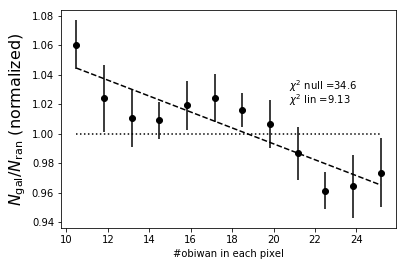

In [71]:
sys_test(hp_obiwan['num_obiwan'],hp_obiwan['num_elgs'],hp_obiwan['num_uniform'],'#obiwan in each pixel')

total number of randoms/objects 446642.0/61544.0
number of randoms/objects outside tested range 51533.0/6727.0
average number of objects per random is 0.1377926840735981
195.881042614
b=1.42510399744 m=-0.00549279176482
22.7815262764


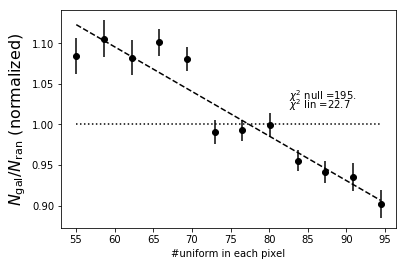

In [72]:
sys_test(hp_obiwan['num_uniform'],hp_obiwan['num_elgs'],hp_obiwan['num_uniform'],'#uniform in each pixel')

total number of randoms/objects 446642.0/61544.0
number of randoms/objects outside tested range 44664.0/6217.0
average number of objects per random is 0.1377926840735981
35.8871113817
b=1.05316326103 m=-0.658069175106
6.66584661418


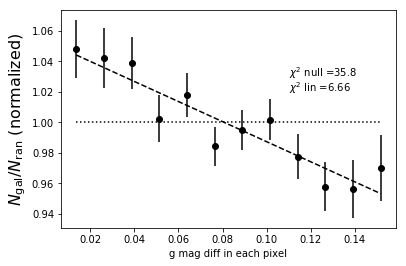

In [73]:
sys_test(hp_obiwan['hist_mag_diff_g']/hp_obiwan['num_obiwan'],\
         hp_obiwan['num_elgs'],hp_obiwan['num_uniform'],'g mag diff in each pixel')

total number of randoms/objects 446642.0/61544.0
number of randoms/objects outside tested range 42958.0/6106.0
average number of objects per random is 0.1377926840735981
28.8499599276
b=0.786070275543 m=-0.382929976237
12.9175791436


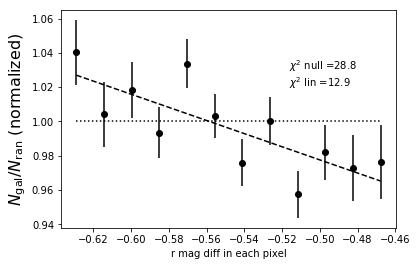

In [74]:
sys_test(hp_obiwan['hist_mag_diff_r']/hp_obiwan['num_obiwan'],\
         hp_obiwan['num_elgs'],hp_obiwan['num_uniform'],'r mag diff in each pixel')

total number of randoms/objects 446642.0/61544.0
number of randoms/objects outside tested range 43807.0/6070.0
average number of objects per random is 0.1377926840735981
13.5811645311
b=0.647892497769 m=-0.218583809375
4.99615181472


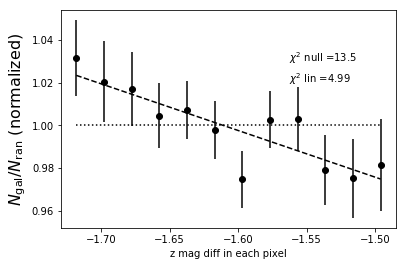

In [75]:
sys_test(hp_obiwan['hist_mag_diff_z']/hp_obiwan['num_obiwan'],\
         hp_obiwan['num_elgs'],hp_obiwan['num_uniform'],'z mag diff in each pixel')

total number of randoms/objects 446642.0/61544.0
number of randoms/objects outside tested range 31693.0/4332.0
average number of objects per random is 0.1377926840735981
30.108217257
b=0.971474870392 m=0.244802940049
22.709679525


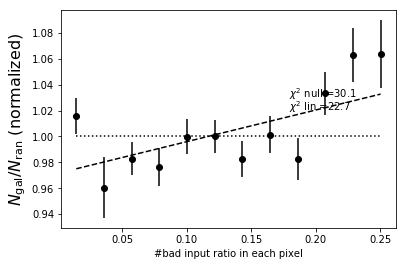

In [76]:
sys_test(hp_obiwan['num_bad']/hp_obiwan['num_obiwan'],hp_obiwan['num_elgs'],\
         hp_obiwan['num_uniform'],'#bad input ratio in each pixel')